# Inventory Optimisation & Demand Forecasting Project (Power BI Ready)

**Project Overview:**
This notebook uses the Kaggle *Store Item Demand Forecasting* dataset to:
- Perform EDA
- Forecast demand using ETS (Exponential Smoothing)
- Calculate EOQ, Safety Stock, and Reorder Points
- Run a Monte Carlo simulation for fill rates


In [6]:
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import norm

# -------------------------
# Config - Change only this
# -------------------------
DATA_PATH = r'E:\AVINASH IITB\Inventory Optimisation and demand forecasting\train.csv'   # Path to Kaggle train.csv
OUT = "outputs"
os.makedirs(OUT, exist_ok=True)

# Inventory policy parameters
ORDERING_COST = 50.0     # per order
HOLDING_RATE = 0.2       # annual holding rate
SERVICE_LEVEL = 0.95
Z = norm.ppf(SERVICE_LEVEL)
FORECAST_HORIZON_DAYS = 30

np.random.seed(42)


In [7]:
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
print("Loaded data:", df.shape)
df.head()


Loaded data: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


            store_id        item_id         demand
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000


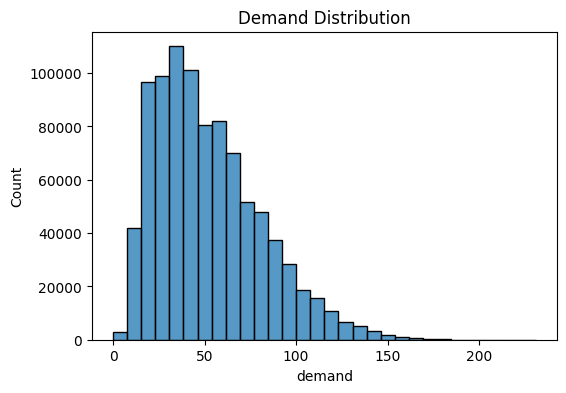

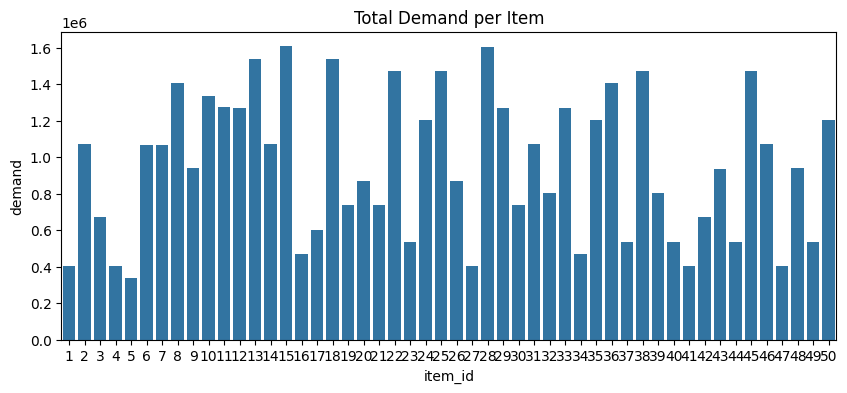

In [8]:
df = df.rename(columns={"store":"store_id", "item":"item_id", "sales":"demand"})

print(df.describe())

plt.figure(figsize=(6,4))
sns.histplot(df["demand"], bins=30)
plt.title("Demand Distribution")
plt.show()

item_totals = df.groupby("item_id")["demand"].sum().reset_index()
plt.figure(figsize=(10,4))
sns.barplot(data=item_totals.sort_values("demand", ascending=False), x="item_id", y="demand")
plt.title("Total Demand per Item")
plt.show()


In [9]:
unique_items = df["item_id"].unique()
price_map = {it: round(np.random.uniform(10,200),2) for it in unique_items}
cost_map = {it: round(price_map[it]*np.random.uniform(0.4,0.75),2) for it in unique_items}
lead_time_map = {it: int(np.random.randint(3,15)) for it in unique_items}
lead_time_std_map = {it: max(1,int(np.random.randint(0,4))) for it in unique_items}

item_totals["cumsum"] = item_totals["demand"].cumsum()
item_totals["cumpct"] = item_totals["cumsum"] / item_totals["demand"].sum()
def abc(p):
    if p<=0.8: return "A"
    if p<=0.95: return "B"
    return "C"
item_totals["ABC"] = item_totals["cumpct"].apply(abc)


In [10]:
def forecast_series(ts, periods=FORECAST_HORIZON_DAYS):
    ts = ts.asfreq("D").fillna(0)
    try:
        model = ExponentialSmoothing(ts, seasonal=None, trend='add', damped_trend=True).fit()
        f = model.forecast(periods)
    except Exception:
        f = pd.Series([ts.mean()]*periods, index=pd.date_range(ts.index[-1]+timedelta(days=1), periods=periods))
    return f

top_items = item_totals.head(5)["item_id"].tolist()
forecasts = []
for it in top_items:
    for st in df["store_id"].unique()[:3]:
        sub = df[(df.item_id==it) & (df.store_id==st)].set_index("date").sort_index()
        ts = sub["demand"].asfreq("D").fillna(0)
        f = forecast_series(ts, periods=FORECAST_HORIZON_DAYS)
        out = pd.DataFrame({"item_id":it, "store_id":st, "date":f.index, "actual_demand":np.nan, "forecast":f.values})
        # Merge actuals for overlapping period
        act = sub.reset_index()
        act.rename(columns={"demand":"actual_demand"}, inplace=True)
        out = pd.concat([act, out]).drop_duplicates(subset=["date"], keep="last")
        out["forecast"] = out["forecast"].fillna(np.nan)
        forecasts.append(out)

forecast_df = pd.concat(forecasts, ignore_index=True)
forecast_df.to_csv(os.path.join(OUT,"forecast_data.csv"), index=False)
forecast_df.head()


,date,store_id,item_id,actual_demand,forecast
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [11]:
agg = df.groupby(["item_id","store_id"]).agg(
    daily_mean=("demand","mean"),
    daily_std=("demand","std")
).reset_index()
agg["unit_cost"] = agg["item_id"].map(cost_map)
agg["price"] = agg["item_id"].map(price_map)
agg["lead_time_mean"] = agg["item_id"].map(lead_time_map)
agg["lead_time_std"] = agg["item_id"].map(lead_time_std_map)
agg["annual_demand"] = agg["daily_mean"] * 365
agg["H"] = agg["unit_cost"] * HOLDING_RATE
agg["EOQ"] = np.sqrt((2 * agg["annual_demand"] * ORDERING_COST) / agg["H"]).replace([np.inf,-np.inf], 1).fillna(1).round()
agg["sigma_lt"] = np.sqrt(agg["daily_std"]**2 * agg["lead_time_mean"] + (agg["lead_time_std"]**2) * (agg["daily_mean"]**2))
agg["Safety_Stock"] = (Z * agg["sigma_lt"]).round()
agg["ROP"] = (agg["daily_mean"] * agg["lead_time_mean"] + agg["Safety_Stock"]).round()


In [12]:
def monte_carlo_fill_rate(d_mean, d_std, lt_mean, lt_std, rop, order_qty, runs=100, days=90):
    rng = np.random.default_rng(123)
    total_shortfall = 0
    total_demand = 0
    for run in range(runs):
        inv = order_qty
        on_order = []
        for day in range(days):
            demand = max(0, int(rng.normal(d_mean, max(0.1, d_std))))
            total_demand += demand
            arrivals = [q for (a,q) in on_order if a==day]
            if arrivals:
                inv += sum(arrivals)
                on_order = [(a,q) for (a,q) in on_order if a!=day]
            if demand <= inv:
                inv -= demand
            else:
                total_shortfall += (demand - inv)
                inv = 0
            if inv <= rop:
                lt = max(1, int(abs(int(rng.normal(lt_mean, max(0.1, lt_std))))))
                on_order.append((day+lt, order_qty))
    return 1.0 - (total_shortfall/total_demand) if total_demand>0 else 1.0

agg["Fill_Rate"] = agg.apply(lambda r: monte_carlo_fill_rate(r.daily_mean, r.daily_std,
                                                            r.lead_time_mean, r.lead_time_std,
                                                            int(r.ROP), int(r.EOQ)), axis=1)

agg["Holding_Cost"] = agg["EOQ"]/2 * agg["unit_cost"] * HOLDING_RATE
agg["Ordering_Cost"] = (agg["annual_demand"]/agg["EOQ"]) * ORDERING_COST

# Merge ABC classification
agg = agg.merge(item_totals[["item_id","ABC"]], on="item_id", how="left")
agg.rename(columns={"ABC":"ABC_Classification"}, inplace=True)

agg.to_csv(os.path.join(OUT,"dashboard_data.csv"), index=False)
agg.head()


,item_id,store_id,daily_mean,daily_std,unit_cost,price,lead_time_mean,lead_time_std,annual_demand,H,EOQ,sigma_lt,Safety_Stock,ROP,Fill_Rate,Holding_Cost,Ordering_Cost,ABC_Classification
0,1,1,19.971522,6.741022,60.01,81.16,9,1,7289.605696,12.002,246.0,28.422423,47.0,227.0,1.000000,1476.246,1481.627174,A
1,1,2,28.173604,8.681013,60.01,81.16,9,1,10283.365279,12.002,293.0,38.366545,63.0,317.0,0.999864,1758.293,1754.840491,A
2,1,3,25.070099,7.897391,60.01,81.16,9,1,9150.585980,12.002,276.0,34.493896,57.0,283.0,0.999964,1656.276,1657.714852,A
3,1,4,22.938664,7.348810,60.01,81.16,9,1,8372.612267,12.002,264.0,31.815520,52.0,258.0,1.000000,1584.264,1585.722020,A
4,1,5,16.739321,5.772961,60.01,81.16,9,1,6109.852136,12.002,226.0,24.086273,40.0,191.0,1.000000,1356.226,1351.737198,A
